In [ ]:
import pandas as pd
import numpy as np
import os
import zipfile
import requests
import shutil
import time
from tqdm.notebook import tqdm
import PIL
import pprint
from termcolor import colored
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, accuracy_score

import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# Utility functions

In [ ]:
def handle_directory_existence(directory_path):
    """ creates the directory if it does not already exist """
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# ---------------------------------------------------
def generate_scanpath(sequence_path: str, x_col: str, y_col: str):
    """
    sequence_path: path to a single csv sequence file
    x_col, y_col: columns to be used as coordinates
    saves the scanpath representation with the same name and path 
    structure as the sequence file in another folder called 'scanpaths'
    """
    sequence = pd.read_csv(sequence_path)

    # remove invalid rows:
    sequence = sequence[sequence.iloc[:, 0] != -1]
    # show fixations points:
    cmap = ['plasma', 'Greys'][0]
    plt.scatter(sequence[x_col], sequence[y_col], c=sequence.index, cmap=cmap, alpha=0.5)
    # show connections:
    plt.plot(sequence[x_col], sequence[y_col], alpha=0.3, c='k')
    # set sxes limits:
    plt.axis([0, 1100, 0, 1100])
    # set origin to (top) left 
    plt.gca().invert_yaxis()
    plt.axis('off')
    dest_path = sequence_path.replace('sequences', 'scanpaths').replace('csv', 'png')
    handle_directory_existence(os.sep.join(dest_path.split(os.sep)[:-1]))
    plt.savefig(dest_path, bbox_inches='tight')
    plt.clf()

# ---------------------------------------------------

def generate_scanpaths_from_sequences(path_to_sequences: str, x_col: str, y_col: str):
    class_folders = os.listdir(path_to_sequences)
    for class_folder in class_folders:
        for sequence_name in tqdm(os.listdir(os.path.join(path_to_sequences, class_folder))):
            sequence_path = os.path.join(path_to_sequences, class_folder, sequence_name)
            generate_scanpath(sequence_path, x_col='r_GazePointX (ADCSpx)', y_col='r_GazePointY (ADCSpx)')

# ---------------------------------------------------

def print_metrics(metrics: dict):
    """ prints the metrics"""
    for metric, value in metrics.items():
        if type(value) == dict:
            value = {k: str(value[k])[:6] for k in value.keys()}
        else: 
            value = str(value)[:6]
        if metric == 'loss':
            loss_metric, loss_value = (metric, value)
        else:
            print(f"\t - {metric} {''.join(['.'] * (15 - len(metric)))} : {value}")
    print(f"\t - {loss_metric} {''.join(['.'] * (15 - len(loss_metric)))} : {loss_value}")

# ---------------------------------------------------

def average_metrics(metrics: list) -> dict:
    """
    receives a list of dictionaries with metric names as keys
    values can be either: 
      - a single number (for a single fold) or 
      - a dictionary in the form {'mean': value, 'std': value} (for a single repetition)
    """
    if type(list(metrics[0].values())[0]) == dict:
        return {k: {'mean': np.mean([m[k]['mean'] for m in metrics]), 'std': np.std([m[k]['mean'] for m in metrics])} for k in metrics[0].keys()}
    else:
        return {k: {'mean': np.mean([m[k] for m in metrics]), 'std': np.std([m[k] for m in metrics])} for k in metrics[0].keys()}

# ---------------------------------------------------

def save_cv_results(cv_results: dict, dest: str, rep: int):
    results = pd.DataFrame()
    for set_type in ['test', 'valid', 'train']:
        for fold, fold_dict in enumerate(cv_results[set_type]):
            for metric in fold_dict.keys():
                results.loc[fold, f'{set_type}_{metric}'] = fold_dict[metric]
    results.insert(0, 'fold', results.index)
    handle_directory_existence(dest)
    results = results.round(5)
    results.to_csv(os.path.join(dest, f'evaluation_seed_{rep}.csv'), index=False)

# ---------------------------------------------------

def save_rcv_results(rcv_results: dict, dest: str):
    results = pd.DataFrame()
    for set_type in ['test', 'valid', 'train']:
        for seed, seed_dict in enumerate(rcv_results[set_type]):
            for metric in seed_dict.keys():
                results.loc[seed, f'{set_type}_{metric}_mean'] = seed_dict[metric]['mean']
                results.loc[seed, f'{set_type}_{metric}_std'] = seed_dict[metric]['std']
    results.insert(0, 'seed', results.index)
    handle_directory_existence(dest)
    results = results.round(5)
    results.to_csv(os.path.join(dest, f'evaluation_all_seeds.csv'), index=False)

In [ ]:
class ETDataset():

    def __init__(self, modalities: list, max_seq_length: int, image_shape: tuple, path_to_sequences, path_to_images):
        self.path_to_sequences = path_to_sequences
        self.path_to_images = path_to_images
        self.modalities = modalities
        self.max_seq_length = max_seq_length
        self.image_shape = image_shape

    def preprocess_sequence(self, sequence):
        sequence = tf.expand_dims(sequence, axis=0)
        sequence = tf.keras.preprocessing.sequence.pad_sequences(
            sequence, maxlen=self.max_seq_length, dtype='float32', 
            padding='pre', truncating='pre', value=0)
        sequence = tf.squeeze(sequence, axis=0)
        return sequence

    def load_csv(self, filename: str, columns: list=None):
        path = os.path.join(self.path_to_sequences, filename + '.csv')
        if columns:
            sequence = pd.read_csv(path, usecols=columns).values
        else:
            sequence = pd.read_csv(path).values
        sequence = self.preprocess_sequence(sequence)
        return sequence

    def preprocess_image(self, image):
        im = image.resize((self.image_shape[0], self.image_shape[1]), Image.ANTIALIAS)
        # im = ImageOps.grayscale(im)
        # im = np.expand_dims(np.array(im), axis=-1)
        return im

    def load_image(self, filename: str):
        path = os.path.join(self.path_to_images, filename + '.png')
        image = PIL.Image.open(path).convert('RGB')
        image = self.preprocess_image(image)
        return image

    def load_nparray(self, filenames: list, labels: list):
        """
        loads nparrays of shape (examples, shape_of_each_example) for each modality
        modalities: list of posssible modalities options include [sequence, image]
        """
        dataset = {'x': {}, 'y': np.array(labels)}

        if 'sequence' in self.modalities:
            cols = ['r_GazePointX (ADCSpx)', 'r_GazePointY (ADCSpx)', 'DistanceLeft', 'PupilLeft', 'PupilRight']
            dataset['x']['rnn'] = np.stack([self.load_csv(filename, columns=cols) for filename in filenames])

        if 'image' in self.modalities:
            dataset['x']['cnn'] = np.stack([self.load_image(filename) for filename in filenames])

        return dataset
        # return tf.data.Dataset.from_tensor_slices((dataset['x']['rnn'], tf.data.Dataset.from_tensor_slices(dataset['y'])))

    # -------------------------------------------------------------------------
    def load_csv_datasets(self, t: tf.Tensor):
        filename = t.numpy().decode('utf-8')
        return self.load_csv(filename)

    def load_image_datasets(self, t: tf.Tensor):
        filename = t.numpy().decode('utf-8')
        return self.load_image(filename)

    def load_dataset(self, filenames: list, labels: list):
        """
        loads the datasets
        modalities: list of posssible modalities options include [sequence, image]
        """
        y = tf.data.Dataset.from_tensor_slices(labels)
        dataset = {'x': {}, 'y': y}

        dataset_filenames = tf.data.Dataset.from_tensor_slices(filenames)

        if 'sequence' in self.modalities:
            dataset['x']['rnn'] = dataset_filenames.map(lambda x: tf.py_function(
                func=self.load_csv_datasets, inp=[x], Tout=tf.float32), num_parallel_calls=tf.data.AUTOTUNE)

        if 'image' in self.modalities:
            dataset['x']['cnn'] = dataset_filenames.map(lambda x: tf.py_function(
                func=self.load_image_datasets, inp=[x], Tout=tf.float32), num_parallel_calls=tf.data.AUTOTUNE)

        return tf.data.Dataset.zip((dataset['x']['rnn'], dataset['y']))
    # -------------------------------------------------------------------------

In [ ]:
class Splitter():

    def __init__(self, path_to_modalities: str, n_splits: int):
        self.path_to_sequences = os.path.join(path_to_modalities, 'sequences')
        self.path_to_scanpaths = os.path.join(path_to_modalities, 'scanpaths')
        self.n_splits = n_splits
        self.classes = {}

    def get_group(self, filename: str) -> str:
        """ Grouping policy """ 
        return filename.split('-')[0]

    def read_filenames(self):
        """
        reads all filenames inside the sequence folder with their corresponding group and label
        """
        for class_folder in os.listdir(self.path_to_sequences):

            label = class_folder.split('_')[0]
            self.classes[label] = {}

            class_filenames = [f[:-4] for f in os.listdir(os.path.join(self.path_to_sequences, class_folder))]
            self.classes[label]['filenames'] = np.array([os.path.join(class_folder, f) for f in class_filenames])
            self.classes[label]['groups'] = np.array([self.get_group(filename) for filename in class_filenames])
            self.classes[label]['y'] = np.array([int(label)]*len(self.classes[label]['filenames']))

    def split(self, seed: int):
        """
        splits the filenames into {n_split} folds
        seed: different seeds result in different splits
        """
        self.read_filenames()
        self.seed = seed
        gss = GroupShuffleSplit(n_splits=self.n_splits, test_size=1/self.n_splits, random_state=self.seed)
        splited = []

        for fold in range(self.n_splits):

            X_train_filenames, X_valid_filenames, X_test_filenames = [], [], []
            y_train, y_valid, y_test = [], [], []

            for label in self.classes.keys():

                X_filenames = self.classes[label]['filenames']
                y = self.classes[label]['y']
                groups = self.classes[label]['groups']
                
                train_valid_index, test_index = list(gss.split(X_filenames, y, groups))[fold]
                train_index, valid_index = list(gss.split(X_filenames[train_valid_index], y[train_valid_index], groups[train_valid_index]))[fold]

                X_train_filenames.extend(list(X_filenames[train_valid_index][train_index])), y_train.extend(list(y[train_valid_index][train_index]))
                X_valid_filenames.extend(list(X_filenames[train_valid_index][valid_index])), y_valid.extend(list(y[train_valid_index][valid_index]))
                X_test_filenames.extend(list(X_filenames[test_index])),   y_test.extend(list(y[test_index]))

            fold_filenames = {
                'train': (X_train_filenames, y_train), 
                'valid': (X_valid_filenames, y_valid), 
                'test' : (X_test_filenames,  y_test)
                }

            splited.append(fold_filenames)

        self.splited = splited

    def get_split_info(self) -> list:
        """ 
        shows how the data has been splited in each fold
        """
        split_info = []
        for fold_filenames in self.splited:

            fold_info = {
                'train' : list(set([self.get_group(item.split(os.sep)[-1]) for item in fold_filenames['train'][0]])),
                'valid' : list(set([self.get_group(item.split(os.sep)[-1]) for item in fold_filenames['valid'][0]])),
                'test'  : list(set([self.get_group(item.split(os.sep)[-1]) for item in fold_filenames['test'][0]]))
            }
            split_info.append(fold_info)

        return split_info
    
    def load_splited_datasets(self, fold: int, modalities: list, max_seq_length: int=50, image_shape: tuple=(150, 150)) -> dict:
        """
        loads the data based on the fold fold_filenames
        modalities: list of posssible modalities options include [sequence, image]
        """

        fold_filenames = self.splited[fold]
        X_train_filenames, y_train = fold_filenames['train']
        X_valid_filenames, y_valid = fold_filenames['valid']
        X_test_filenames , y_test  = fold_filenames['test']

        etdataset = ETDataset(modalities, max_seq_length, image_shape, self.path_to_sequences, self.path_to_scanpaths)
        load_arrays = True
        train_dataset   = etdataset.load_nparray(X_train_filenames, y_train) if load_arrays else etdataset.load_dataset(X_train_filenames, y_train)
        valid_dataset   = etdataset.load_nparray(X_valid_filenames, y_valid) if load_arrays else etdataset.load_dataset(X_valid_filenames, y_valid)
        test_dataset    = etdataset.load_nparray(X_test_filenames,  y_test)  if load_arrays else etdataset.load_dataset(X_test_filenames,  y_test)

        datasets = {
            'train': train_dataset,
            'valid': valid_dataset,
            'test' : test_dataset
        }

        return datasets
  
    def save_split_to_file(self, path_to_fold_splits: str):
        df = pd.DataFrame(self.get_split_info())
        df.insert(0, 'fold', df.index)
        handle_directory_existence(path_to_fold_splits)
        path = os.path.join(path_to_fold_splits, f'folds_seed_{self.seed}.csv')
        df.to_csv(path, index=False)

# Model

In [ ]:
class Models():
    
    def rnn(self, input_shape: tuple):

        rnn_input = keras.Input(shape=input_shape, name='rnn')
        # rnn_features = tf.compat.v1.keras.layers.CuDNNGRU(128, return_sequences=False)(rnn_input)
        rnn_features = tf.compat.v1.keras.layers.GRU(128, return_sequences=False)(rnn_input)
        rnn_features = layers.Dropout(0.4)(rnn_features)
        rnn_features = layers.Dense(50, activation='relu')(rnn_features)
        rnn_output = layers.Dense(2, activation='softmax')(rnn_features)
        
        rnn_model = keras.Model(inputs=rnn_input, outputs=rnn_output)
        return rnn_model

    def cnn(self, input_shape: tuple):

        cnn_input = keras.Input(shape=input_shape, name='cnn')
        cnn_input_scaled = layers.experimental.preprocessing.Rescaling(1./255)(cnn_input)
        cnn_features = layers.Conv2D(32, kernel_size=(5, 5), activation='relu')(cnn_input_scaled)
        cnn_features = layers.MaxPooling2D(pool_size=(2, 2))(cnn_features)
        cnn_features = layers.Flatten()(cnn_features)
        cnn_features = layers.Dense(50, activation='relu')(cnn_features)
        cnn_output = layers.Dense(2, activation='softmax')(cnn_features)

        cnn_model = keras.Model(inputs=cnn_input, outputs=cnn_output)
        return cnn_model

    def vtnet(self, input_shapes: dict):

        rnn = self.rnn(input_shapes['rnn'])
        rnn_input, rnn_features = rnn.input, rnn.layers[-2].output
        
        cnn = self.cnn(input_shapes['cnn'])
        cnn_input, cnn_features = cnn.input, cnn.layers[-2].output
        
        concatenated_features = layers.concatenate([rnn_features, cnn_features])
        logits = layers.Dense(20)(concatenated_features)
        vtnet_output = layers.Dense(2, activation='softmax')(logits)
        
        vtnet_model = keras.Model(inputs=[rnn_input, cnn_input], outputs=vtnet_output)
        return vtnet_model


In [ ]:
""" model hyper-parameters """
NUM_TIMESTEPS, NUM_FEATURES = (200, 5)
IMAGE_H, IMAGE_W, IMAGE_C = (150, 150, 3)

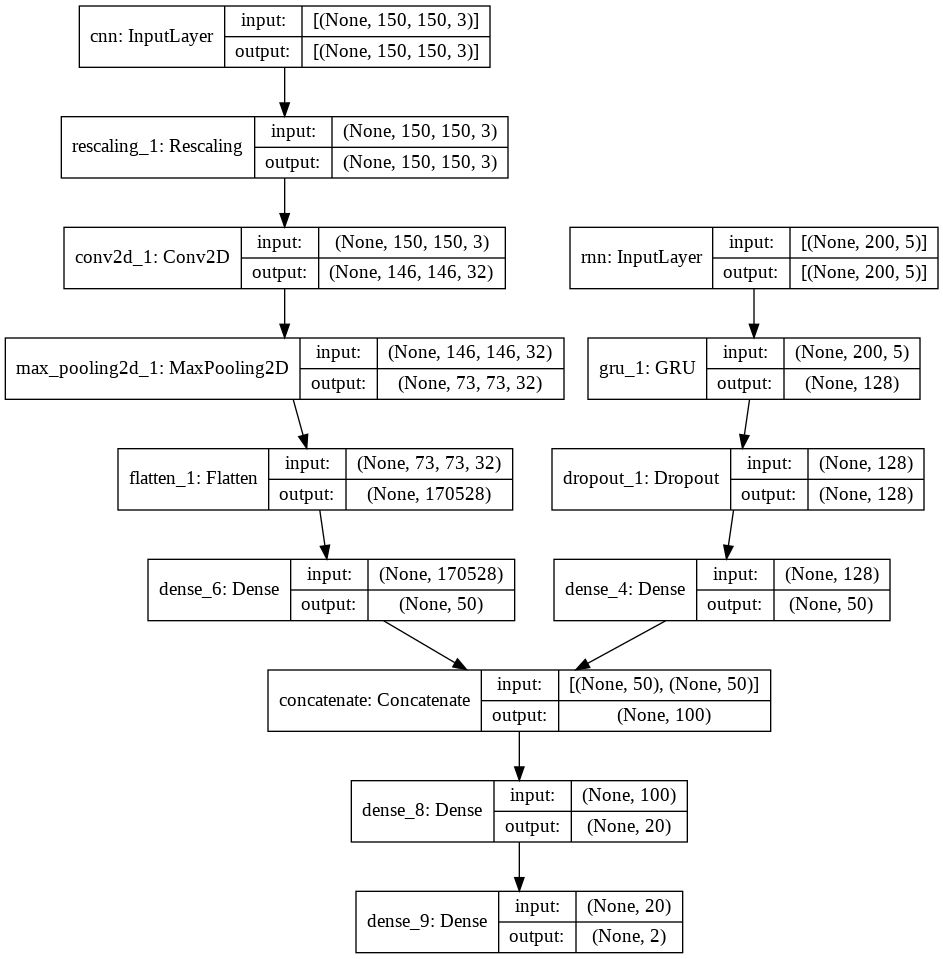

In [ ]:
def create_model(model_name: str):
    models = {
        'rnn': Models().rnn((NUM_TIMESTEPS, NUM_FEATURES)),
        'cnn': Models().cnn((IMAGE_H, IMAGE_W, IMAGE_C)),
        'vtnet': Models().vtnet({'rnn': (NUM_TIMESTEPS, NUM_FEATURES), 'cnn': (IMAGE_H, IMAGE_W, IMAGE_C)})
    }
      
    model = models[model_name]

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),  
        #'binary_crossentropy', tf.keras.losses.CategoricalCrossentropy(), tfa.losses.SigmoidFocalCrossEntropy()
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6, decay=1e-5),

        metrics=[
          'accuracy', 
          tf.metrics.Recall(class_id=0, name='recall_0'), 
          tf.metrics.Recall(class_id=1, name='recall_1'),
          tf.keras.metrics.AUC(name='AUC')
          ]
    )
    return model

model = create_model(model_name='vtnet')

# callbacks:
name = f'log_{int(time.time())}'
tensorboard = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=f'logs/{name}')
csv_logger = tf.keras.callbacks.CSVLogger('training.log')
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5)
callbacks = [tensorboard, earlystopping]

tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Data Handling

In [ ]:
TARGET = ['Meara', 'BarChartLit'][0]
SEC = 1
EXPERIMENT_NAME = f'{TARGET}_({SEC})'
timestamp = time.strftime("%Y%m%d-%H%M%S")

# paths:
PATH_TO_MODALITIES = os.path.join('Data', f'{TARGET} ({SEC} sec)')
PATH_TO_SEQS = os.path.join('Data', f'{TARGET} ({SEC} sec)', 'sequences')
PATH_TO_SCANPATHS = os.path.join('Data', f'{TARGET} ({SEC} sec)', 'scanpaths')

PATH_TO_OUTPUTS = 'Results'
PATH_TO_EXPERIMENT = os.path.join(PATH_TO_OUTPUTS, f'{EXPERIMENT_NAME}_{timestamp}')
PATH_TO_EVALUATION_RESULTS = os.path.join(PATH_TO_EXPERIMENT, 'Evaluation')
PATH_TO_FOLD_SPLITS = os.path.join(PATH_TO_EXPERIMENT, 'Splits')

In [ ]:
""" GITHUB DATA RETRIEVAL EXECUTABLE """

# shutil.rmtree('Data')

if not os.path.exists(f'Data/{TARGET} ({SEC} sec)'):
    url = f'https://github.com/Alireza-Iranpour/MSNV_DL/raw/main/Data/{TARGET}%20({SEC}%20sec).zip'
    r = requests.get(url, allow_redirects=True)
    open('Data.zip', 'wb').write(r.content)
    zip_ref = zipfile.ZipFile('Data.zip', 'r')

    if not os.path.exists('Data'):
        os.mkdir('Data')

    zip_ref.extractall('Data')
    zip_ref.close()
    print(f'Data/{TARGET} ({SEC} sec) was successfully added!')

Data/Meara (1 sec) was successfully added!


In [ ]:
try: 
    zip_ref = zipfile.ZipFile(f'{TARGET} ({SEC} sec).zip', 'r')

    if not os.path.exists('Data'):
        os.mkdir('Data')

    zip_ref.extractall('Data')
    zip_ref.close()
except:
    pass

In [ ]:
""" generate scanpaths of all sequences """
if False:
    generate_scanpaths_from_sequences(PATH_TO_SEQS, x_col='r_GazePointX (ADCSpx)', y_col='r_GazePointY (ADCSpx)')

# Show fold splits

In [ ]:
""" Print fold data for a given seed (each item represents a group of data points) """

SHOW = False
SEED = 0
K = 10

pp = pprint.PrettyPrinter(compact=True)

splitter = Splitter(PATH_TO_MODALITIES, K)
splitter.split(SEED)

if SHOW:
    split_info = splitter.get_split_info()
    for fold in range(K):
        print(colored(f'fold {fold}: ', 'blue'))
        pp.pprint(split_info[fold])
        print('\n')

# Repeated Cross Validation

In [ ]:
MAX_SEQ_LEN = NUM_TIMESTEPS

K = 10
START_SEED = 0
NUM_REPETITIONS = 1
NUM_EPOCHS = 50
BATCH_SIZE = 50

In [ ]:
num_reps = NUM_REPETITIONS
num_folds = K
# shutil.rmtree('logs')

splitter = Splitter(PATH_TO_MODALITIES, K)

rcv_results = {'train': [], 'valid': [], 'test': []}

for rep in range(START_SEED, num_reps):

    print(f'\n################# (repetition {rep+1}/{num_reps}) #################')

    # Split based on the seed of the repetition before performing CV
    splitter.split(seed=rep)
    splitter.save_split_to_file(PATH_TO_FOLD_SPLITS)

    cv_results = {'train': [], 'valid': [], 'test': []}

    for fold in range(num_folds):

        fold_datasets = splitter.load_splited_datasets(fold, modalities=['sequence', 'image'], max_seq_length=MAX_SEQ_LEN, image_shape=(IMAGE_H, IMAGE_W))

        print(f'\n------------- Training: (fold {fold+1}/{num_folds}) -------------\n')
        train_dataset, valid_dataset, test_dataset = fold_datasets['train'], fold_datasets['valid'], fold_datasets['test']

        # train_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)
        # valid_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)

        # x = train_dataset.map(lambda x, y: x)
        # y = train_dataset.map(lambda x, y: y)


        model = create_model(model_name='rnn')

        train_results = model.fit(train_dataset['x'], tf.one_hot(train_dataset['y'], 2),
                                  validation_data=(valid_dataset['x'], tf.one_hot(valid_dataset['y'], 2)), 
                                  epochs=NUM_EPOCHS,
                                  batch_size=BATCH_SIZE,
                                  verbose=1, 
                                  callbacks=callbacks)

        print(f'\n------------- Evaluation: (fold {fold+1}/{num_folds}) -------------\n')
        train_results = model.evaluate(train_dataset['x'], tf.one_hot(train_dataset['y'], 2))
        valid_results = model.evaluate(valid_dataset['x'], tf.one_hot(valid_dataset['y'], 2))
        test_results  = model.evaluate(test_dataset['x'], tf.one_hot(test_dataset['y'], 2))

        train_metrics = dict(zip(model.metrics_names, train_results))
        valid_metrics = dict(zip(model.metrics_names, valid_results))
        test_metrics  = dict(zip(model.metrics_names, test_results))

        cv_results['train'].append(train_metrics)
        cv_results['valid'].append(valid_metrics)
        cv_results['test'].append(test_metrics)

        print('\nfold validation:\n')
        print_metrics(valid_metrics)
        print('\nfold test:\n') 
        print_metrics(test_metrics)

    # Average CV metrics across folds for validation and test
    cv_train_avg = average_metrics(cv_results['train']) 
    cv_valid_avg = average_metrics(cv_results['valid']) 
    cv_test_avg  = average_metrics(cv_results['test'])
    save_cv_results(cv_results=cv_results, dest=PATH_TO_EVALUATION_RESULTS, rep=rep)

    print(f'\n*********************(repetition {rep+1}/{num_reps} results)**************************')

    print('\nrepetition validation:\n')
    print_metrics(cv_valid_avg)
    print('\nrepetition test:\n') 
    print_metrics(cv_test_avg)

    print('\n***************************************************************************************')

    rcv_results['train'].append(cv_train_avg)
    rcv_results['valid'].append(cv_valid_avg)
    rcv_results['test'].append(cv_test_avg)

# Average RCV metrics across repetitions for validation and test
rcv_train_avg = average_metrics(rcv_results['train'])
rcv_valid_avg = average_metrics(rcv_results['valid'])
rcv_test_avg  = average_metrics(rcv_results['test'])
save_rcv_results(rcv_results=rcv_results, dest=PATH_TO_EVALUATION_RESULTS)

print('\n***************************************************************************************')
print('\n****************************** Final Evaluation Results *******************************')
print('\n***************************************************************************************')

print('\nfinal validation:\n')
print_metrics(rcv_valid_avg)
print('\nfinal test:\n') 
print_metrics(rcv_test_avg)


################# (repetition 1/1) #################

------------- Training: (fold 1/10) -------------

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['cnn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


47/47 [==============================] - 20s 365ms/step - loss: 0.9311 - accuracy: 0.5010 - recall_0: 0.1826 - recall_1: 0.8321 - AUC: 0.4826 - val_loss: 0.8226 - val_accuracy: 0.5203 - val_recall_0: 0.2222 - val_recall_1: 0.8476 - val_AUC: 0.4743
Epoch 2/50
17/47 [=========>....................] - ETA: 9s - loss: 0.9112 - accuracy: 0.4941 - recall_0: 0.1747 - recall_1: 0.8539 - AUC: 0.4847 

KeyboardInterrupt: ignored

# Experiments

In [ ]:
roc_threshold = 0.5
valid_y_scores = model.predict(valid_dataset['x'])
# valid_y_true, valid_y_pred = valid_dataset['y'], np.array(valid_y_scores >= roc_threshold, dtype=np.int).flatten()  # binary
valid_y_true, valid_y_pred = valid_dataset['y'], np.array(tf.argmax(valid_y_scores, 1)).flatten() # multiclass

test_y_scores = model.predict(test_dataset['x'])
# test_y_true, test_y_pred = test_dataset['y'], np.array(test_y_scores >= roc_threshold, dtype=np.int).flatten()  # binary
test_y_true, test_y_pred = test_dataset['y'], np.array(tf.argmax(test_y_scores, 1)).flatten() # multiclass

val_metrics = compute_metrics(valid_y_true, valid_y_pred, valid_y_scores.max(axis=1)) # for binary remove .max()
test_metrics = compute_metrics(test_y_true, test_y_pred, test_y_scores.max(axis=1))   # for binary remove .max()

# print('\nvalidation:\n')
# pprint_metrics(val_metrics)
# print('\ntest:\n') 
# pprint_metrics(test_metrics)

In [ ]:
splitter = Splitter(PATH_TO_MODALITIES, K)
splitter.split(seed=1)
fold_datasets = splitter.load_splited_datasets(1, modalities=['sequence'], max_seq_length=MAX_SEQ_LEN, image_shape=(150, 150))
train_dataset, valid_dataset, test_dataset = fold_datasets['train'], fold_datasets['valid'], fold_datasets['test']

In [ ]:
# print(train_dataset['x']['rnn'].shape)
# print(train_dataset['y'])

#x = train_dataset[0]
#y = train_dataset[1]
# d = d.batch(2)
for element in train_dataset:
  #print(element)
  break

<MapDataset shapes: <unknown>, types: tf.float32>

(150, 150, 3, 1)


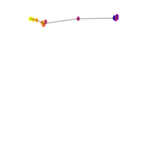

In [ ]:
# image processing snippet:

path = '/content/Data/Meara (1 sec)/scanpaths/0_low/L1-11-1.png'
im = PIL.Image.open(path).convert('RGB')
# image = im.resize((150, 150), Image.ANTIALIAS)
# image = ImageOps.grayscale(image)
print(np.expand_dims(np.array(image), axis=-1).shape)
image

In [ ]:
filenames= ['/content/Data/Meara (1 sec)/sequences/0_low/L1-11-1.csv', '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv']
d = tf.data.Dataset.from_tensor_slices(['hello', 'world'])
# transform a string tensor to upper case string using a Python function
def upper_case_fn(t: tf.Tensor):
  return t.numpy().decode('utf-8').upper()
d = d.map(lambda x: tf.py_function(func=upper_case_fn,
          inp=[x], Tout=tf.string))

dataset = dataset.map(lambda x: x + 1,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False)

In [ ]:
filenames= ['/content/Data/Meara (1 sec)/sequences/0_low/L1-11-1.csv', 
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv',
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv',
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv',
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv',
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-2.csv', 
            '/content/Data/Meara (1 sec)/sequences/0_low/L1-11-3.csv']

labels = [1, 1, 1, 1, 0, 0, 0]

d = tf.data.Dataset.from_tensor_slices(filenames)
y = tf.data.Dataset.from_tensor_slices(labels)

def process_paths(t: tf.Tensor):
  path = t.numpy().decode('utf-8')
  sequence = pd.read_csv(path).values
  sequence = tf.expand_dims(sequence, axis=0)
  sequence = tf.keras.preprocessing.sequence.pad_sequences(
      sequence, maxlen=50, dtype='float32', 
      padding='pre', truncating='pre', value=0)
  sequence = tf.squeeze(sequence, axis=0)
  return sequence

d = d.map(lambda x: tf.py_function(func=process_paths, inp=[x], Tout=tf.float32))
dataset = tf.data.Dataset.zip((d, y))
# d = d.batch(3).prefetch(2)


model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
model.fit(dataset, epochs=1)

for z in dataset:
  print(z)
  break

ValueError: ignored

In [ ]:
d

<MapDataset shapes: <unknown>, types: tf.float32>

In [ ]:
pred = model.predict(test_dataset['x'])
pred

array([[0.5150976 , 0.48490235],
       [0.514298  , 0.48570195],
       [0.4987722 , 0.5012278 ],
       [0.49138373, 0.50861627],
       [0.4935286 , 0.50647134],
       [0.49265835, 0.5073416 ],
       [0.50774384, 0.4922561 ],
       [0.49299395, 0.50700605],
       [0.5121858 , 0.48781416],
       [0.50692064, 0.4930794 ],
       [0.5049989 , 0.4950011 ],
       [0.49899256, 0.50100744],
       [0.48820788, 0.5117921 ],
       [0.5106027 , 0.48939726],
       [0.5051882 , 0.49481177],
       [0.4977598 , 0.50224024],
       [0.50047   , 0.49953002],
       [0.5227854 , 0.47721452],
       [0.5186937 , 0.48130634],
       [0.51950014, 0.48049986],
       [0.48514616, 0.51485384],
       [0.50298905, 0.49701098],
       [0.49556035, 0.5044397 ],
       [0.49457353, 0.50542647],
       [0.49960962, 0.50039035],
       [0.49195248, 0.5080476 ],
       [0.50254476, 0.49745527],
       [0.49556404, 0.50443596],
       [0.49772006, 0.50228   ],
       [0.4927822 , 0.5072178 ],
       [0.

In [ ]:
tf.argmax(pred, 1)

<tf.Tensor: shape=(352,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
     

In [ ]:
valid_y_true

<tf.Tensor: shape=(344, 2), dtype=float32, numpy=
array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]

In [ ]:
def generate_scanpath(sequence_path: str, x_col: str, y_col: str):

  sequence = pd.read_csv(sequence_path)

  # remove invalid rows:
  sequence = sequence[sequence.iloc[:, 0] != -1]
  # show fixations points:
  cmap = ['plasma', 'Greys'][0]
  plt.scatter(sequence[x_col], sequence[y_col], c=sequence.index, cmap=cmap, alpha=0.5)
  # show connections:
  plt.plot(sequence[x_col], sequence[y_col], alpha=0.3, c='k')
  # set sxes limits:
  plt.axis([0, 1100, 0, 1100])
  # set origin to (top) left 
  plt.gca().invert_yaxis()
  plt.axis('off')
  # dest_path = sequence_path.replace('sequence', 'scanpath').replace('csv', 'png')
  # plt.savefig(dest_path, bbox_inches='tight')
  # plt.clf()


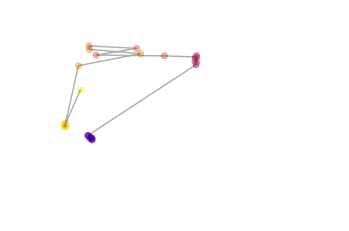

In [ ]:
# sequence = pd.read_csv('/content/Data/Meara (1 sec)/sequences/0_low/L18-11-1.csv')
sequence_path = '/content/Data/Meara (1 sec)/sequences/0_low/L16-11-1.csv'
generate_scanpath(sequence_path, x_col='r_GazePointX (ADCSpx)', y_col='r_GazePointY (ADCSpx)')

In [ ]:
path = '/content/Data/Meara (1 sec)/scanpaths/0_low/L1-11-1.png'
im = PIL.Image.open(path).convert('RGB')
im
np.array(im).shape

(231, 349, 3)

In [ ]:
dict(zip(model.metrics_names, valid_results))



{'AUC': 0.6305259466171265,
 'accuracy': 0.6067073345184326,
 'loss': 0.6655838489532471,
 'recall_0': 0.9539473652839661,
 'recall_1': 0.3068181872367859}

In [ ]:
print(f"\t - {'hi'} {''.join(['.'] * (15 - len('hi')))} : {8}")

	 - hi ............. : 8


In [ ]:
''.join(['.'] * (15 - len('hi')))

'.............'

In [ ]:
(list(test_metrics.values())[0])

0.39034709334373474

In [ ]:
a = 0.39034709334373474
print(str(a)[:6])

0.3903
